## The Plan

In [ ]:
# Key Analysis Components
# 1. Rating Analysis

# Compares overall rating distributions before and after August 22, 2023
# Tracks weekly average ratings to identify any immediate or gradual shifts
# Visualizes changes in rating patterns over time

# 2. Sentiment Analysis

# Uses NLTK's VADER sentiment analyzer to measure positive, negative, and neutral sentiment
# Compares sentiment scores before and after AI summaries were introduced
# Creates visualizations of sentiment changes

# 3. Product Feature Extraction and Analysis

# Uses spaCy for NLP to identify product features mentioned in reviews
# Identifies the most commonly mentioned features before and after
# Analyzes how sentiment toward specific features changed

# 4. Review Complexity Analysis

# Measures text length and lexical diversity to see if reviews became more or less detailed
# Examines if users focused on different aspects after seeing AI summaries

# 5. Topic Modeling

# Uses Latent Dirichlet Allocation (LDA) to identify key topics in reviews
# Compares dominant topics before and after AI summaries
# Creates word clouds to visualize changes in vocabulary

# 6. Paired t-test


In [125]:
# What to Look For in the Results

# Rating shifts: Did average ratings increase or decrease after AI summaries?
# Sentiment changes: Did reviews become more positive or negative overall?
# Feature focus: Did users mention different product features after seeing AI summaries?
# Review complexity: Did reviews become more detailed or diverse in vocabulary?
# Topic differences: Did the main topics of discussion change after AI summaries?

# Importing packages

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy
from textblob import TextBlob
import ssl

import sys
import os

# Add the project root directory to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src.utils.logger import logger
from config import Config, Directory

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yonah/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yonah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yonah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load the saved CSV file

In [138]:

# Load the saved CSV file
df = pd.read_csv(os.path.join(Directory.RAW_DATA.value, f"{Config().product_category}.csv"))

logger.info(f"\nLoaded dataset with {len(df)} reviews")

# Add a datetime column for easier analysis
df['review_date'] = pd.to_datetime(df['timestamp'], unit='ms')

# Create period labels
df['period'] = 'during_transition'  # Default value for any reviews that don't fit in before/after
ai_start_date = datetime(2023, 8, 22)
df.loc[df['review_date'] < ai_start_date, 'period'] = 'before_ai'
df.loc[df['review_date'] >= ai_start_date, 'period'] = 'after_ai'

# Print basic stats about the periods
logger.info("\n\nReviews by period:")
period_counts = df['period'].value_counts()
for period, count in period_counts.items():
    print(f"\n{period}: {count} reviews ({count/len(df)*100:.1f}%)")

# Check if we have the expected columns
logger.info(f"\n\nDataset columns: {df.columns.tolist()}")

2025-03-06 21:44:47,277 [INFO] 
Loaded dataset with 26725 reviews
2025-03-06 21:44:47,282 [INFO] 

Reviews by period:
2025-03-06 21:44:47,284 [INFO] 

Dataset columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'review_date', 'period']



before_ai: 19673 reviews (73.6%)

after_ai: 7052 reviews (26.4%)


# Analyze rating distribution before and after

2025-03-06 21:12:13,668 [INFO] 

--- RATING ANALYSIS ---
2025-03-06 21:12:13,683 [INFO] 

                mean  median  count
period                            
after_ai   4.487096     5.0   7052
before_ai  4.469832     5.0  19673
2025-03-06 21:12:13,733 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-06 21:12:13,745 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


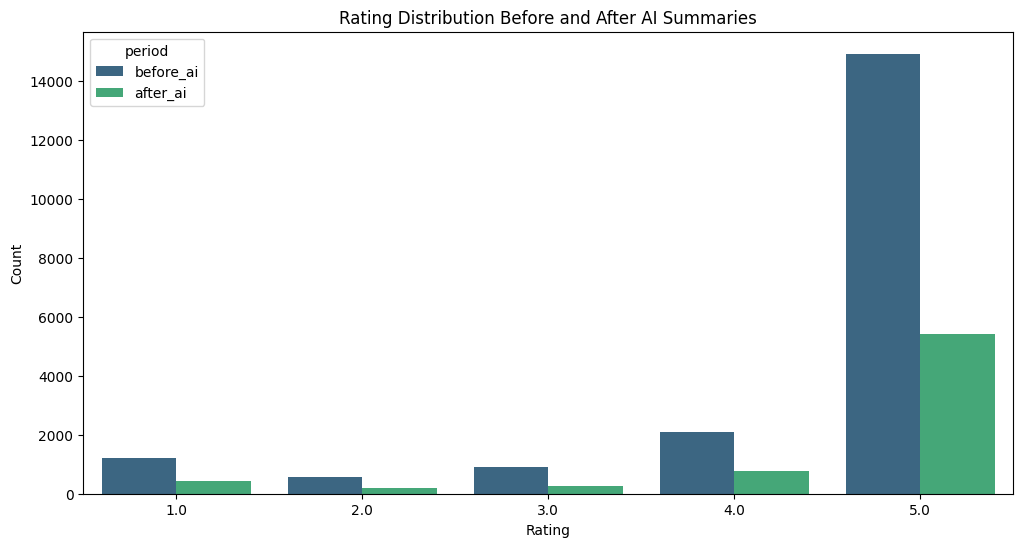

In [133]:
# Analyze rating distribution before and after
logger.info("\n\n--- RATING ANALYSIS ---")
rating_by_period = df.groupby('period')['rating'].agg(['mean', 'median', 'count'])
logger.info(f"\n\n {rating_by_period}")

# Plot rating distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='rating', hue='period', data=df, palette='viridis')
plt.title('Rating Distribution Before and After AI Summaries')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig(os.path.join(Directory.FIGURES.value,'rating_distribution.png'))

## Average rating over time (weekly)

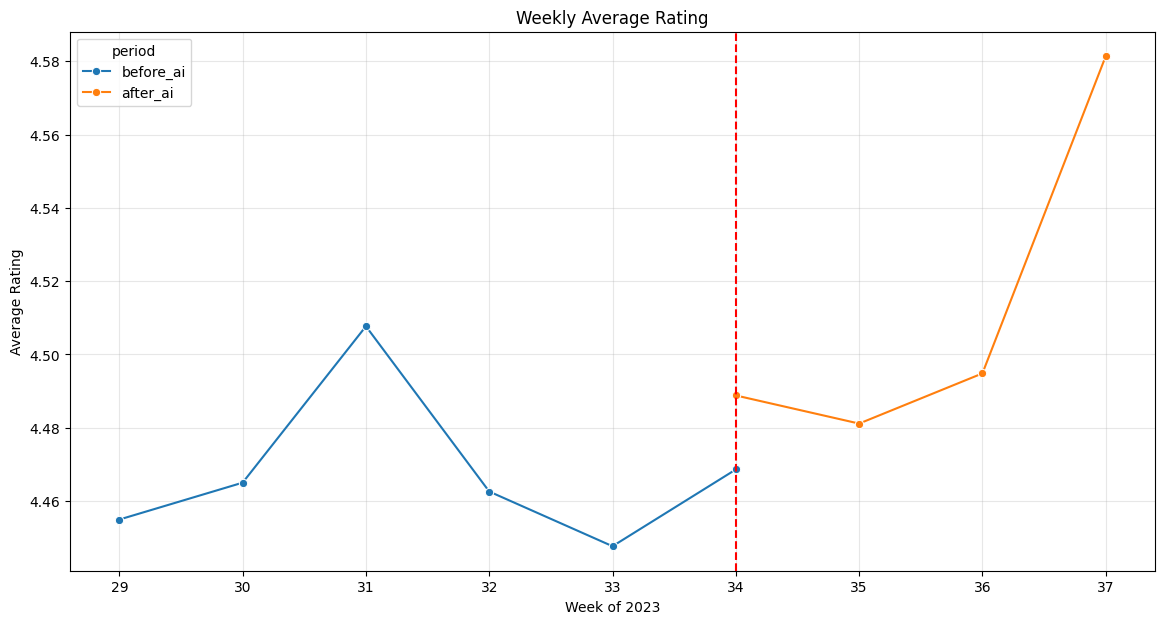

In [121]:

# Plot average rating over time (weekly)
df['week'] = df['review_date'].dt.isocalendar().week
weekly_ratings = df.groupby(['week', 'period'])['rating'].mean().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(x='week', y='rating', hue='period', data=weekly_ratings, marker='o')
plt.axvline(x=ai_start_date.isocalendar().week, color='red', linestyle='--', 
            label='AI Summary Introduction (Aug 22)')
plt.title('Weekly Average Rating')
plt.xlabel('Week of 2023')
plt.ylabel('Average Rating')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(Directory.FIGURES.value, 'weekly_ratings.png'))

## --- SENTIMENT ANALYSIS: TextBlob ---

In [135]:
from textblob import TextBlob

# Calculate sentiment scores for review text
logger.info("\n\n--- SENTIMENT ANALYSIS ---")

# Function to get sentiment using TextBlob
def get_sentiment_textblob(text):
    if not isinstance(text, str) or not text.strip():
        return {'polarity': 0, 'subjectivity': 0}
    
    blob = TextBlob(text)
    return {
        'polarity': blob.sentiment.polarity,  # Range from -1 (negative) to 1 (positive)
        'subjectivity': blob.sentiment.subjectivity  # Range from 0 (objective) to 1 (subjective)
    }

# Apply sentiment analysis to review text
df['sentiment'] = df['text'].apply(get_sentiment_textblob)
df['polarity'] = df['sentiment'].apply(lambda x: x['polarity'])
df['subjectivity'] = df['sentiment'].apply(lambda x: x['subjectivity'])

# Compare sentiment before and after
sentiment_by_period = df.groupby('period')[['polarity', 'subjectivity']].mean()
logger.info(f"\n\n {sentiment_by_period}")

2025-03-06 21:13:52,187 [INFO] 

--- SENTIMENT ANALYSIS ---
2025-03-06 21:13:56,258 [INFO] 

            polarity  subjectivity
period                           
after_ai   0.294534      0.539124
before_ai  0.293892      0.534965


## --- SENTIMENT ANALYSIS: Vader ---

In [136]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_sentiment_vader(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Initialize VADER
    analyzer = SentimentIntensityAnalyzer()

    # Get sentiment scores
    sentiment = analyzer.polarity_scores(text)

    return sentiment['compound']

df['sentiment'] = df['text'].apply(get_sentiment_vader)

# Compare sentiment before and after
sentiment_by_period = df.groupby('period')['sentiment'].mean()
logger.info(sentiment_by_period)

2025-03-06 21:16:51,094 [INFO] period
after_ai     0.579090
before_ai    0.571349
Name: sentiment, dtype: float64


## Extract most common product features


--- FEATURE EXTRACTION AND ANALYSIS ---
Extracting features from reviews...

Top 20 features mentioned BEFORE AI summaries:
this book: 7141
the book: 3198
the story: 1353
the author: 1076
great book: 794
the characters: 731
a lot: 684
book: 660
love: 599
the end: 546
a book: 530
this one: 529
readers: 514
life: 466
this story: 446
the world: 439
the way: 432
this series: 427
people: 423
the series: 408

Top 20 features mentioned AFTER AI summaries:
this book: 2802
the book: 1212
the story: 539
the author: 404
great book: 329
the characters: 304
a lot: 254
book: 220
life: 215
the end: 210
readers: 210
love: 207
this one: 200
a book: 181
the series: 167
kids: 166
this story: 163
people: 151
great read: 150
the world: 148
Calculating sentiment for feature: great book
Calculating sentiment for feature: the story
Calculating sentiment for feature: the book
Calculating sentiment for feature: the author
Calculating sentiment for feature: this book

--- FEATURE SENTIMENT CHANGES ---
great boo

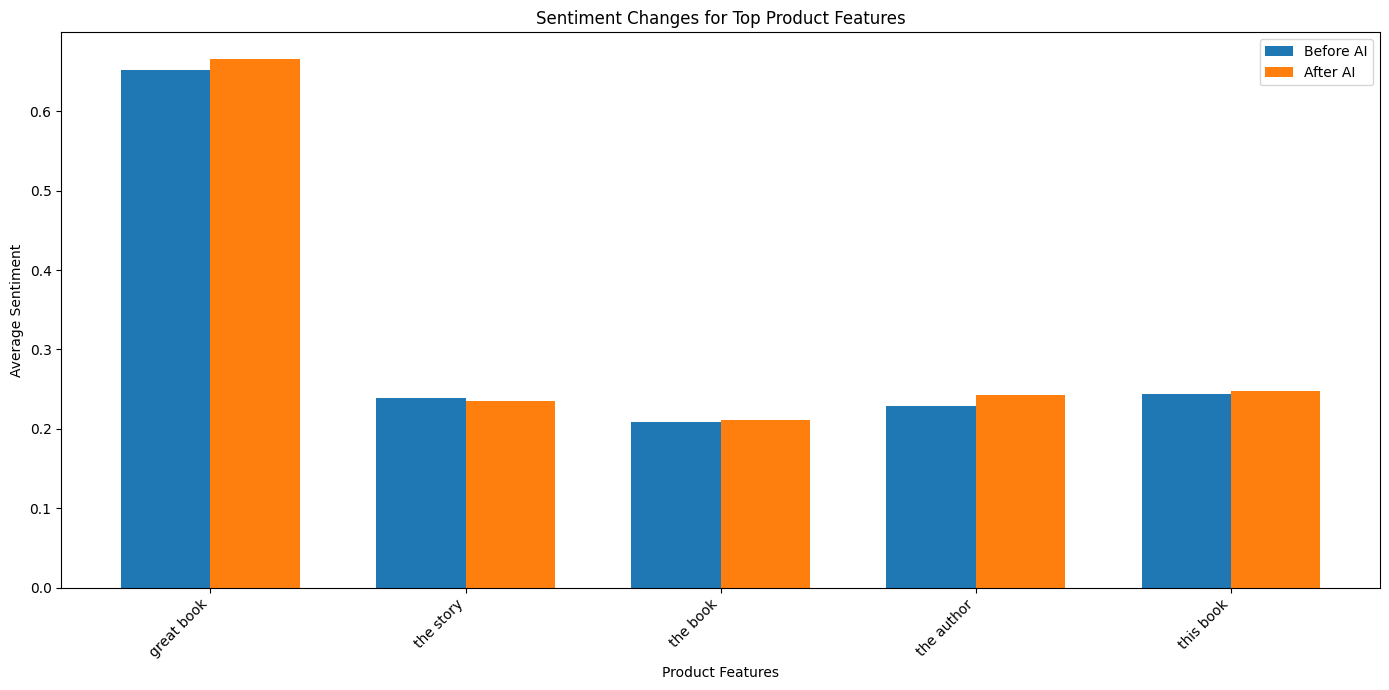

In [ ]:

# Extract most common product features using NLP
logger.info("\n--- FEATURE EXTRACTION AND ANALYSIS ---")

# Load spaCy model for better feature extraction
nlp = spacy.load("en_core_web_sm")

# Feature extraction function
def extract_features(text):
    if not isinstance(text, str):
        return []
    
    doc = nlp(text.lower())
    
    # Extract noun phrases and product-related terms
    features = []
    for chunk in doc.noun_chunks:
        if any(token.pos_ in ['NOUN', 'PROPN'] for token in chunk):
            features.append(chunk.text)
    
    # Add additional relevant adjective-noun pairs
    for token in doc:
        if token.dep_ == 'amod' and token.head.pos_ in ['NOUN', 'PROPN']:
            features.append(f"{token.text} {token.head.text}")
    
    return features

# Apply feature extraction (this may take some time)
logger.info("Extracting features from reviews...")
df['extracted_features'] = df['text'].apply(extract_features)

# Count feature occurrences before and after
# before_features = [feature for features in df[df['period'] == 'before_ai']['extracted_features'] 
#                  for feature in features]
# after_features = [feature for features in df[df['period'] == 'after_ai']['extracted_features'] for feature in features]

# get all rows where period is 'before_ai'
before_ai_rows = df[df['period'] == 'before_ai']
# Get just the 'extracted_features' column from those rows
before_features_lists = before_ai_rows['extracted_features']
before_features = []
for features_list in before_features_lists:
    for feature in features_list:
        before_features.append(feature)

# for after_ai
after_ai_rows = df[df['period'] == 'after_ai']
after_features_lists = after_ai_rows['extracted_features']
after_features = []
for features_list in after_features_lists:
    for feature in features_list:
        after_features.append(feature)

# Get top features
before_counter = Counter(before_features)
after_counter = Counter(after_features)

logger.info("\nTop 20 features mentioned BEFORE AI summaries:")
for feature, count in before_counter.most_common(20):
    logger.info(f"{feature}: {count}")

logger.info("\nTop 20 features mentioned AFTER AI summaries:")
for feature, count in after_counter.most_common(20):
    logger.info(f"{feature}: {count}")

# Calculate feature sentiment
def get_feature_sentiment(row, feature):
    if not isinstance(row['text'], str):
        return None
    if feature in row['text'].lower():
        # Get the sentence containing the feature
        sentences = re.split(r'[.!?]', row['text'].lower())
        feature_sentences = [s for s in sentences if feature in s]
        if feature_sentences:
            # Calculate sentiment for those sentences
            sentiment = TextBlob(' '.join(feature_sentences)).sentiment.polarity
            return sentiment
    return None

# Analyze sentiment for top 5 features in each period
top_before_features = [f for f, _ in before_counter.most_common(5)]
top_after_features = [f for f, _ in after_counter.most_common(5)]

# Combine unique features
top_features = list(set(top_before_features + top_after_features))

# Calculate sentiment for each top feature
feature_sentiments = {}
for feature in top_features:
    logger.info(f"Calculating sentiment for feature: {feature}")
    df[f'sentiment_{feature}'] = df.apply(lambda row: get_feature_sentiment(row, feature), axis=1)
    
    # Get average sentiment by period
    before_sentiment = df[df['period'] == 'before_ai'][f'sentiment_{feature}'].mean()
    after_sentiment = df[df['period'] == 'after_ai'][f'sentiment_{feature}'].mean()
    
    feature_sentiments[feature] = {
        'before_ai': before_sentiment,
        'after_ai': after_sentiment,
        'change': after_sentiment - before_sentiment if not (pd.isna(before_sentiment) or pd.isna(after_sentiment)) else None
    }

# Display feature sentiment changes
logger.info("\n--- FEATURE SENTIMENT CHANGES ---")
for feature, sentiments in feature_sentiments.items():
    if sentiments['change'] is not None:
        change_str = f"{sentiments['change']:.4f}"
        direction = "increased" if sentiments['change'] > 0 else "decreased"
        logger.info(f"{feature}: Sentiment {direction} by {change_str}")

# Create a visualization of feature sentiment changes
features = []
before_vals = []
after_vals = []

for feature, sentiments in feature_sentiments.items():
    if sentiments['before_ai'] is not None and sentiments['after_ai'] is not None:
        features.append(feature)
        before_vals.append(sentiments['before_ai'])
        after_vals.append(sentiments['after_ai'])

if features:
    plt.figure(figsize=(14, 7))
    width = 0.35
    x = np.arange(len(features))
    
    plt.bar(x - width/2, before_vals, width, label='Before AI')
    plt.bar(x + width/2, after_vals, width, label='After AI')
    
    plt.xlabel('Product Features')
    plt.ylabel('Average Sentiment')
    plt.title('Sentiment Changes for Top Product Features')
    plt.xticks(x, features, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(Directory.FIGURES.value,'feature_sentiment_changes.png'))

## --- REVIEW COMPLEXITY ANALYSIS ---


--- REVIEW COMPLEXITY ANALYSIS ---
           text_length  lexical_diversity
period                                   
after_ai     54.729013           0.853129
before_ai    52.868551           0.856512


<Figure size 1200x600 with 0 Axes>

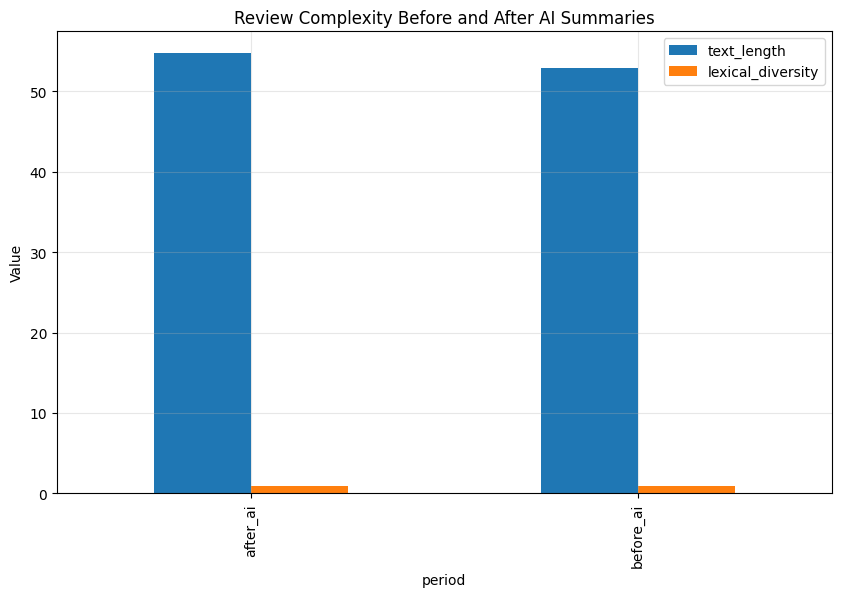

In [ ]:
# Analyze complexity and specificity of reviews
logger.info("\n--- REVIEW COMPLEXITY ANALYSIS ---")

# Calculate review text length
df['text_length'] = df['text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Calculate unique words per review (lexical diversity)
def lexical_diversity_simple(text):
    if not isinstance(text, str) or len(text.split()) == 0:
        return 0
    # Simple tokenization by splitting on whitespace
    words = text.lower().split()
    # Remove punctuation from each word
    words = [re.sub(r'[^\w\s]', '', word) for word in words]
    # Filter out empty strings
    words = [word for word in words if word]
    if not words:
        return 0
    return len(set(words)) / len(words)

df['lexical_diversity'] = df['text'].apply(lexical_diversity_simple)

# Calculate average values by period
complexity_metrics = df.groupby('period')[['text_length', 'lexical_diversity']].mean()
logger.info(complexity_metrics)

# Plot review complexity metrics
plt.figure(figsize=(12, 6))
complexity_metrics.plot(kind='bar', figsize=(10, 6))
plt.title('Review Complexity Before and After AI Summaries')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(Directory.FIGURES.value, 'review_complexity.png'))

## --- TOPIC MODELING ---


--- TOPIC MODELING ---

Topics BEFORE AI summaries:
Topic 1: book, read, story, one, characters, series, loved, love, reading, put
Topic 2: book, story, life, read, readers, love, highly, world, young, recommend
Topic 3: book, read, like, would, one, dont, good, much, people, know
Topic 4: book, great, easy, recipes, coloring, fun, information, pictures, helpful, use
Topic 5: book, great, good, love, condition, read, perfect, books, quality, came

Topics AFTER AI summaries:
Topic 1: book, recipes, easy, guide, great, history, information, informative, read, journey
Topic 2: love, book, condition, came, books, arrived, quality, great, gift, perfect
Topic 3: great, book, kids, fun, illustrations, children, love, coloring, beautiful, read
Topic 4: book, story, read, loved, love, characters, one, series, books, like
Topic 5: book, good, read, really, like, reading, great, one, enjoyed, got

Analysis complete!


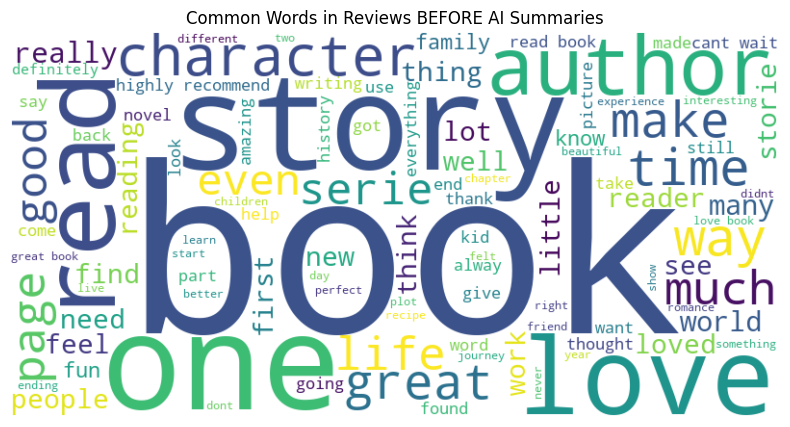

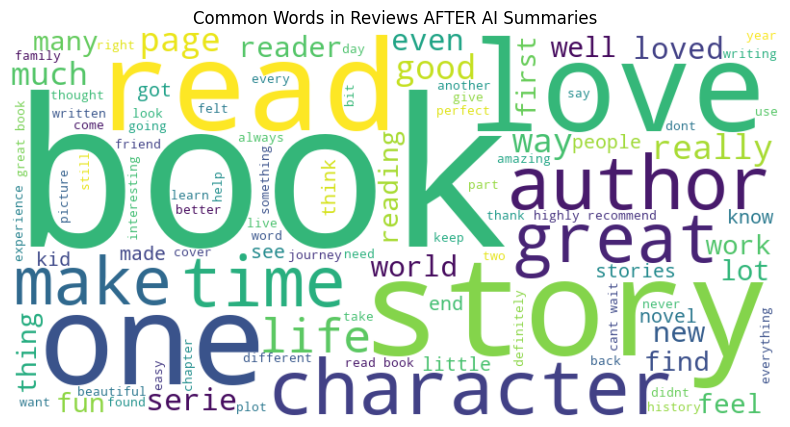

In [ ]:

# Topic modeling to identify changes in review content
logger.info("\n--- TOPIC MODELING ---")

# Prepare text for topic modeling
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

df['processed_text'] = df['text'].apply(preprocess_text)

# Perform topic modeling separately for before and after periods
def extract_topics(text_data, n_topics=5):
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(text_data)
    feature_names = vectorizer.get_feature_names_out()
    
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-10-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
    
    return topics

before_topics = extract_topics(df[df['period'] == 'before_ai']['processed_text'])
after_topics = extract_topics(df[df['period'] == 'after_ai']['processed_text'])

logger.info("\nTopics BEFORE AI summaries:")
for i, topic in enumerate(before_topics):
    logger.info(f"Topic {i+1}: {', '.join(topic)}")

logger.info("\nTopics AFTER AI summaries:")
for i, topic in enumerate(after_topics):
    logger.info(f"Topic {i+1}: {', '.join(topic)}")

# Create word clouds for before and after periods
before_text = ' '.join(df[df['period'] == 'before_ai']['processed_text'])
after_text = ' '.join(df[df['period'] == 'after_ai']['processed_text'])

def generate_wordcloud(text, title, filename):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.savefig(filename)

generate_wordcloud(before_text, 'Common Words in Reviews BEFORE AI Summaries', os.path.join(Directory.FIGURES.value, 'before_ai_wordcloud.png'))
generate_wordcloud(after_text, 'Common Words in Reviews AFTER AI Summaries', os.path.join(Directory.FIGURES.value, 'after_ai_wordcloud.png'))

logger.info("\nAnalysis complete!")